Code to generate Figure 10 in 'Rethinking Discount Regularization'

#Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import ExtraTreesRegressor
import multiprocessing
from matplotlib.ticker import MaxNLocator

#Environment


In [ ]:
def T(state,action,noise_variance=.05):
  """ Model of T to use in policy evaluation

  """

  p = np.random.uniform()

  #Right
  if action == 0:
    if p < 0.5:
      next_state = np.random.uniform()
      #next_state = state + epsilon #stay in same state  #reduced pct stay/increase move right
    elif p < .95:
      next_state = state + .2 + noise_variance*np.random.uniform() #move right
    else:
      next_state = state - .2 + noise_variance*np.random.uniform() # move left

  elif action==1:
    if p<.25:
      next_state = np.random.uniform()
    else:
      next_state = state -.2 + noise_variance*np.random.uniform()

  if (next_state<=0):  #reached left reward
    next_state = 0
  elif next_state >= 1 : #reached right reward
    next_state = 1

  return next_state


def reward(s):
  return (s-.5)**2 + 2*((s-.5)**3)

Text(0.5, 1.0, 'Transition Distributions')

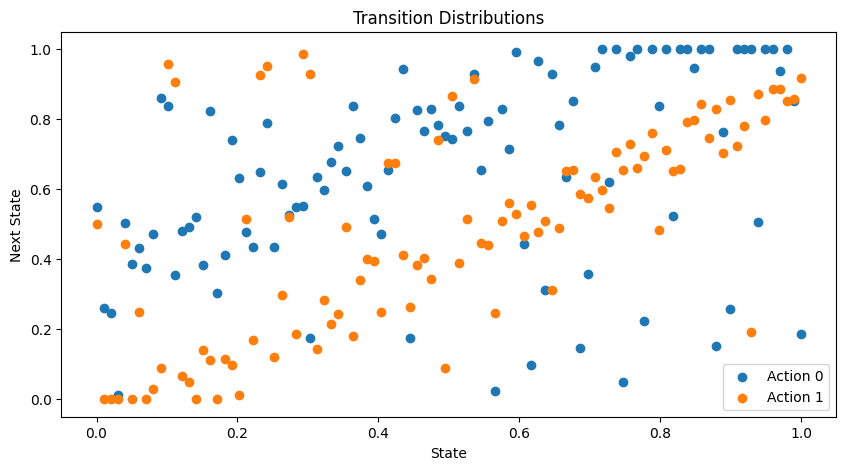

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10, 5))

noise = .2

x = np.linspace(0,1,100)
y = np.array([T(s,0,noise) for s in x])

ax.scatter(x,y,label='Action 0')
ax.set_xlabel('State')
ax.set_ylabel('Next State')

x = np.linspace(0,1,100)
y = np.array([T(s,1,noise) for s in x])
ax.scatter(x,y,label='Action 1')
ax.set_xlabel('State')
ax.set_ylabel('Next State')

ax.legend()
ax.set_title("Transition Distributions")

In [ ]:
class ContinuousRiverSwim():

  def __init__(self,noise_variance = .2):
    self.num_steps = 0
    self.state = np.random.uniform()
    self.terminated = False
    self.noise_variance = noise_variance
    self.small_reward = .1
    self.large_reward = 1 #TODO put back to 1

  def reset(self):
    self.state = np.random.uniform()
    self.terminated = False

  def step(self,action):
    epsilon = np.random.normal(0,self.noise_variance)

    p = np.random.uniform()

    #Right
    if action == 0:
      if p < 0.5:
        next_state = np.random.uniform()
        #next_state = self.state + epsilon #stay in same state  #reduced pct stay/increase move right
      elif p < .95:
        next_state = self.state + .2 + self.noise_variance*np.random.uniform() #move right
      else:
        next_state = self.state - .2 + self.noise_variance*np.random.uniform() # move left

    elif action==1:
      if p<.25:
        next_state = np.random.uniform()
      else:
        next_state = self.state -.2 + self.noise_variance*np.random.uniform()

    if (next_state<=0):  #reached left reward
      next_state = 0
    elif next_state >= 1 : #reached right reward
      next_state = 1



    if (next_state<=0):  #reached left reward
      next_state = 0
      if action == 1:
        reward = self.small_reward
        self.terminated = True
      else:
        reward = 0

    elif next_state >= 1 : #reached right reward
      next_state = 1
      if action == 0:
        reward = self.large_reward
        self.terminated = True
      else:
        reward = 0

    else:
      reward = 0
      self.terminated = False

    #TEMP- try diff reward function
    reward = (self.state-.5)**2 + 2*((self.state-.5)**3) + epsilon

    self.state = next_state

    return self.state,reward,self.terminated


##Reward Function


Text(0.5, 0.98, 'Continuous River Swim Reward')

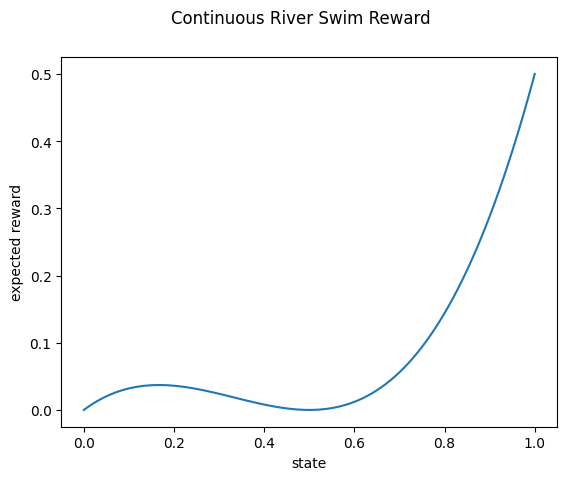

In [ ]:
state = np.arange(0,1.01,.01)
rew = []
for s in state:
  rew.append((s-.5)**2 + 2*((s-.5)**3))

plt.plot(state,rew)
plt.xlabel('state')
plt.ylabel('expected reward')
plt.suptitle('Continuous River Swim Reward')

#Generate Data

In [ ]:
def gen_data(num_traj,max_steps,noise):
  data =pd.DataFrame(columns=['s','a','r','sprime'])
  env = ContinuousRiverSwim(noise_variance=noise)

  for n in range(num_traj):
    env.reset()
    state = env.state
    terminated = False
    step = 1
    while (terminated ==False) & (step <= max_steps):
    #while step <= max_traj_len:

      #random action
      a = np.random.binomial(1,.5)

      #take step
      next_state,reward,terminated = env.step(action=a)

      #update data
      data.loc[len(data.index)] = [state,a,reward,next_state]
      state = next_state
      step+=1
  return data

# Kernel Regression

In [ ]:
#kernel estimate for T

def rbf_kernel(x,x_i,lengthscale=.05):
  return np.exp(-(x-x_i)**2/(2*lengthscale**2))

def w_i(s,a,i,data_df,lengthscale=.05):
  data_df_a = data_df[data_df['a']==a]
  num = rbf_kernel(s,data_df_a['s'].iloc[i],lengthscale)
  denom = np.sum([rbf_kernel(s,s_i) for s_i in data_df_a['s']])
  return num/denom

def T_kernel_reg(s,a,data_df):
  data_df_a = data_df[data_df['a']==a]
  num = np.array([rbf_kernel(s,s_i)*y_i for s_i,y_i in zip(data_df_a['s'],data_df_a['sprime'])])
  denom = np.array([rbf_kernel(s,s_i) for s_i in data_df_a['s']])
  return np.sum(num)/np.sum(denom)


# Epsilon*

In [ ]:
def se_hat(s,a,data):
  sorted_data = data[data['a']==a].sort_values(by=['s'])
  if len(sorted_data)<2:
    return 1
  y_sum_sq = 0
  for i in range(len(sorted_data)-1):
    y_sum_sq += (sorted_data['sprime'].iloc[i+1] - sorted_data['sprime'].iloc[i])**2
  sigma_hat = y_sum_sq/(2*len(sorted_data)-1)

  #calc weights
  all_weights = np.array([w_i(s,a,i,data) for i in range(len(data[data['a']==a]))])

  return sigma_hat*np.sqrt(np.sum(all_weights**2))


def eps_star(s,a,data,m_reg):
  se = se_hat(s,a,data)
  m_hat = T_kernel_reg(s,a,data)
  return se**2/((m_reg-m_hat)**2+se**2)

In [ ]:
def T_eps_kernel_reg(s,a,data_df,eps_sa,reg_state):
  data_df_a = data_df[data_df['a']==a]
  num = [rbf_kernel(s,s_i)*y_i for s_i,y_i in zip(data_df_a['s'],data_df_a['sprime'])]
  denom = [rbf_kernel(s,s_i) for s_i in data_df_a['s']]
  s_prime_kernel = sum(num)/sum(denom)

  s_prime_reg = (1-eps_sa)*s_prime_kernel + eps_sa*reg_state

  return s_prime_reg

# FVI

In [ ]:
def FVI_reg(data_df,fixed_eps_star,R_true,gamma,num_iter,policy_state_grid):

  """
  Adapted from: Finite Time Bounds for Sampling-Based Fitted Value Iteration
  Remi Munos, Csaba Szepesvari
  2008
  (see Section 3)

  Also summarized here:
  https://cs229.stanford.edu/notes2021fall/cs229-notes12.pdf

  Regularize transition distrib with state-action specific transition

  state space: continuous on [0,1]
  action space: {0,1}

  R_true: Reward function of state, assume known
  data_df: pandas data frame ['start_state','action','next_state','reward']

  """

  #randomly sample num_sample_states states to model value
  #using fixed grid instead
  sample_states = policy_state_grid

  #Initialized value function for all sample states
  V_sample_states = np.array([0 for s in sample_states])

  #this is the part where we use the model for T -- no randomness if using kernel reg est so just sample once for each sample state
  #get s_prime from kde for T for every state in sample_states
  eps_sa=fixed_eps_star  #Fixed eps_sa for all (s,a) for now! will change this.
  s_prime_0 = np.array([T_kernel_reg(s,0,data_df) for s in sample_states]).reshape(-1, 1)
  s_prime_1 = np.array([T_kernel_reg(s,1,data_df) for s in sample_states]).reshape(-1, 1)

  for k in range(num_iter):

    if k%100==0:
      print(f'FVI Iteration {k}')

    # get value of next state for all states if take action 0 or 1
    V_sa_reg = ExtraTreesRegressor(n_estimators=100, random_state=0,n_jobs=-1).fit(sample_states.reshape(-1, 1),V_sample_states)
    V_sprime_0 = V_sa_reg.predict(s_prime_0)
    V_sprime_1 = V_sa_reg.predict(s_prime_1)
    V_grid = V_sa_reg.predict(policy_state_grid.reshape(-1,1))

    #get q_0 and q_1 for all sample states
    #testing-- move the weighted averaging here
    q_0 = [R_true(s) + gamma*(1-eps_sa )*V_sprime_0[i] + gamma*eps_sa*np.mean(V_grid) for i,s in enumerate(sample_states)]
    q_1 = [R_true(s) + gamma*(1-eps_sa )*V_sprime_1[i] + gamma*eps_sa*np.mean(V_grid)for i,s in enumerate(sample_states)]

    #update V_sample_states
    V_sample_states = [max(q_0[i],q_1[i]) for i,s in enumerate(sample_states)]


  pi = [0 if q_0[i]>q_1[i] else 1 for i,s in enumerate(policy_state_grid)]
  v_pi = [max(q_0[i],q_1[i]) for i,s in enumerate(policy_state_grid)]

  return pi,v_pi

In [ ]:
def FVI_sa_reg(data_df,R_true,gamma,num_iter,policy_state_grid,eps_s_a0,eps_s_a1):

  """
  Adapted from: Finite Time Bounds for Sampling-Based Fitted Value Iteration
  Remi Munos, Csaba Szepesvari
  2008
  (see Section 3)

  Also summarized here:
  https://cs229.stanford.edu/notes2021fall/cs229-notes12.pdf

  Regularize transition distrib with state-action specific transition

  state space: continuous on [0,1]
  action space: {0,1}

  R_true: Reward function of state, assume known
  data_df: pandas data frame ['start_state','action','next_state','reward']

  """

  #randomly sample num_sample_states states to model value
  #using fixed grid instead
  sample_states = policy_state_grid

  #Initialized value function for all sample states
  V_sample_states = np.array([0 for s in sample_states])

  #this is the part where we use the model for T -- no randomness if using kernel reg est so just sample once for each sample state
  #get s_prime from kde for T for every state in sample_states
  s_prime_0 = np.array([T_kernel_reg(s,0,data_df) for s in sample_states]).reshape(-1, 1)
  s_prime_1 = np.array([T_kernel_reg(s,1,data_df) for s in sample_states]).reshape(-1, 1)

  for k in range(num_iter):

    if k%100==0:
      print(f'FVI Iteration {k}')

    # get value of next state for all states if take action 0 or 1
    V_sa_reg = ExtraTreesRegressor(n_estimators=100, random_state=0,n_jobs=-1).fit(sample_states.reshape(-1, 1),V_sample_states)
    V_sprime_0 = V_sa_reg.predict(s_prime_0)
    V_sprime_1 = V_sa_reg.predict(s_prime_1)
    V_grid = V_sa_reg.predict(policy_state_grid.reshape(-1,1))

    #get q_0 and q_1 for all sample states
    #testing-- move the weighted averaging here
    q_0 = [R_true(s) + gamma*(1-eps_s_a0[i])*V_sprime_0[i] + gamma*eps_s_a0[i]*np.mean(V_grid) for i,s in enumerate(sample_states)]
    q_1 = [R_true(s) + gamma*(1-eps_s_a1[i])*V_sprime_1[i] + gamma*eps_s_a1[i]*np.mean(V_grid)for i,s in enumerate(sample_states)]

    #update V_sample_states
    V_sample_states = [max(q_0[i],q_1[i]) for i,s in enumerate(sample_states)]


  pi = [0 if q_0[i]>q_1[i] else 1 for i,s in enumerate(policy_state_grid)]
  v_pi = [max(q_0[i],q_1[i]) for i,s in enumerate(policy_state_grid)]

  return pi,v_pi

In [ ]:
def eval_pi_no_stochasticity(pi,policy_state_grid,R_true,T,gamma,num_iter):

  """ No multiprocessing.  Use no-noise T, no resamples
  """

  #Initialized value function for all sample states
  V_policy_states = np.array([0 for s in policy_state_grid])

  #sample next state for each sample state
  s_prime_0 = np.array([T(s,0,noise_variance=0) for s in policy_state_grid]).reshape(-1,1)
  s_prime_1 = np.array([T(s,1,noise_variance=0) for s in policy_state_grid]).reshape(-1,1)

  for k in range(num_iter):

    #if j%10==0:
    #  print(f'Iteration {j}')

    V_sa_reg = ExtraTreesRegressor(n_estimators=100, random_state=0,n_jobs=-1).fit(policy_state_grid.reshape(-1, 1),V_policy_states)
    V_sprime_0 = V_sa_reg.predict(s_prime_0)
    V_sprime_1 = V_sa_reg.predict(s_prime_1)

    q_0 = np.array([R_true(s) + gamma*V_sprime_0[i] for i,s in enumerate(policy_state_grid)])
    q_1 = np.array([R_true(s) + gamma*V_sprime_1[i] for i,s in enumerate(policy_state_grid)])

    #update V_sample_states -- THIS IS WHERE WE USE THE POLICY THAT WE'RE EVALUATING
    V_policy_states = np.array([q_0[i] if pi[i]==0 else q_1[i] for i,s in enumerate(policy_state_grid)])

  return V_policy_states

In [ ]:
def trans_resample(x,policy_state_grid,R_true,T,noise,gamma,V_sa_reg):

    #sample next state for each sample state
    s_prime_0 = np.array([T(s,0,noise) for s in policy_state_grid]).reshape(-1,1)
    s_prime_1 = np.array([T(s,1,noise) for s in policy_state_grid]).reshape(-1,1)

    # get value of next state for all states s_prime_0
    #V_sa_reg = ExtraTreesRegressor(n_estimators=100, random_state=0,n_jobs=1).fit(policy_state_grid.reshape(-1, 1),V_policy_states)
    V_sprime_0 = V_sa_reg.predict(s_prime_0)
    V_sprime_1 = V_sa_reg.predict(s_prime_1)

    q_0 = np.array([R_true(s) + gamma*V_sprime_0[i] for i,s in enumerate(policy_state_grid)])
    q_1 = np.array([R_true(s) + gamma*V_sprime_1[i] for i,s in enumerate(policy_state_grid)])

    return q_0,q_1

def eval_pi(pi,policy_state_grid,R_true,T,noise,gamma,num_iter,num_trans_resamples):

  """Multiprocessing version
  """

  #Initialized value function for all sample states
  V_policy_states = np.array([0 for s in policy_state_grid])

  for j in range(num_iter):

    if j%100==0:
      print(f'Eval Iteration {j}')
      #print('avg value',print(np.mean(V_policy_states)))

    V_sa_reg = ExtraTreesRegressor(n_estimators=100, random_state=0,n_jobs=1).fit(policy_state_grid.reshape(-1, 1),V_policy_states)
    with multiprocessing.Pool() as pool:
      result = pool.starmap(trans_resample,[(x,policy_state_grid,R_true,T,noise,gamma,V_sa_reg) for x in range(num_trans_resamples)])

    #set q(a) as average estimate over all resamples
    q_0 = np.sum([l[0] for l in result],axis=0)/num_trans_resamples
    q_1 = np.sum([l[1] for l in result],axis=0)/num_trans_resamples

    #update V_sample_states -- THIS IS WHERE WE USE THE POLICY THAT WE'RE EVALUATING
    V_policy_states = np.array([q_0[i] if pi[i]==0 else q_1[i] for i,s in enumerate(policy_state_grid)])

  return V_policy_states

#Loss

In [ ]:
num_datasets = 1000
true_gamma = 0.99
true_noise = .30
policy_state_grid = np.linspace(0,1,101)
eps_list = [0,.25,.5,.75,0.99]
data_set_size = 20
max_steps = 10

loss_eps = {}
for eps in eps_list:
  loss_eps[eps] = []
sa_loss = []

#get true optimal policy
data = gen_data(1000,max_steps=1,noise=true_noise)
pi_true,v_true = FVI_reg(data,0,reward,gamma=true_gamma,num_iter=300,policy_state_grid=policy_state_grid)
#pi_true = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
#use eval_pi with resamples from true T (with stochasticity) to get oracle value to calc loss
v_true = eval_pi(pi_true,policy_state_grid,reward,T,true_noise,true_gamma,num_iter=300,num_trans_resamples=100)

for d in range(num_datasets):
  print(f'Dataset {d}')
  data = gen_data(data_set_size,max_steps=max_steps,noise=true_noise)

  #regularize with sa-specific eps*
  eps_s_a0 = [eps_star(s,0,data,true_noise) for s in policy_state_grid]
  eps_s_a1 = [eps_star(s,1,data,true_noise) for s in policy_state_grid]
  pi,v = FVI_sa_reg(data,reward,true_gamma,num_iter=300,policy_state_grid=policy_state_grid,eps_s_a0=eps_s_a0,eps_s_a1=eps_s_a1)
  v_pi = eval_pi(pi,policy_state_grid,reward,T,noise=true_noise,gamma=true_gamma,num_iter=300,num_trans_resamples=100)
  sa_loss.append(np.mean([x-y for (x,y) in zip(v_true,v_pi)]))

  #regularize with range of fixed epsilon
  for fixed_eps_star in eps_list:
    pi,v = FVI_reg(data,fixed_eps_star,reward,true_gamma,num_iter=100,policy_state_grid=policy_state_grid)
    v_pi = eval_pi(pi,policy_state_grid,reward,T,noise=true_noise,gamma=true_gamma,num_iter=300,num_trans_resamples=100)
    loss_eps[fixed_eps_star].append(np.mean([x-y for (x,y) in zip(v_true,v_pi)]))

[3.7071162455599245, 3.6290069896147448, 3.6599911299404906, 3.8869953808805393, 4.496915639832766]


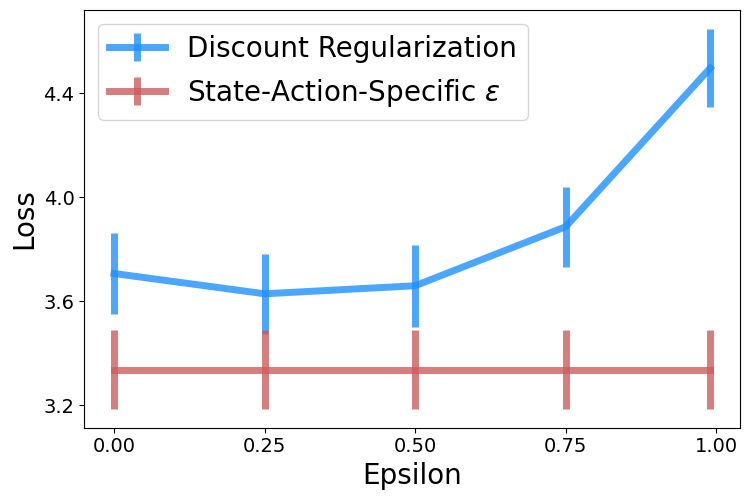

In [6]:
avg_loss = []
stdev_loss = []
for e in loss_eps:
  avg_loss.append(np.mean(loss_eps[e]))
  stdev_loss.append(np.std(loss_eps[e])/np.sqrt(num_datasets))
print(avg_loss)
eps_list = [0,.25,.5,.75,0.99]

fig,ax = plt.subplots(1,1,figsize=(8,6))
ax.errorbar(eps_list,avg_loss,yerr=[2*j for j in stdev_loss],label= 'Discount Regularization',alpha=.8,linestyle='solid',linewidth=5,color='dodgerblue')
ax.errorbar(eps_list,[np.mean(sa_loss) for e in eps_list],yerr=[2*np.std(sa_loss)/np.sqrt(num_datasets) for j in eps_list],label = 'State-Action-Specific $\epsilon$',alpha=.8,linestyle='solid',linewidth=5,color='indianred')

ax.set_xlabel('Epsilon',fontsize=20)
ax.set_ylabel('Loss',fontsize=20)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='both', which='major', labelsize=14)
ax.legend(fontsize=20)
fig.tight_layout(rect=[0.05, 0, 1, 0.85])

plt.savefig('continuous_river_swim.pdf')